# Kapitel 10: Aggregation von Daten und Gruppenoperationen

McKinney, W. (2017). *Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython*. 2. Auflage. Sebastopol, CA [u. a.]: O’Reilly.

Überarbeitet: armin.baenziger@zhaw.ch, 25. Nov. 2020

- Das Kategorisieren eines Datasets und das Anwenden einer Funktion auf jede Gruppe, ob Aggregation oder Transformation, ist häufig eine kritische Komponente eines Datenanalyseworkflows.
- Pandas bietet dazu eine flexible `groupby`-Methode an.
- Hilfreich sind zudem Funktionen für Pivot-Tabellen und Kreuztabellen, welche einen Spezialfall von Pivott-Tabellen darstellen.

In [1]:
%autosave 0

Autosave disabled


In [2]:
# Wichtige Bibliotheken mit üblichen Abkürzungen laden:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Damit Plots direkt im Notebook erscheinen:
%matplotlib inline


## GroupBy-Mechanismen
- Gruppenoperationen lassen sich mit dem Begriff **"Split-Apply-Combine"** beschreiben.
- In der ersten Phase des Prozesses werden Daten, die in einem Pandas-Objekt enthalten sind basierend auf einem oder mehreren Schlüsseln in Gruppen aufgeteilt. 
- Das Teilen wird auf einer bestimmten Achse eines Objekts ausgeführt. Zum Beispiel kann ein DataFrame in seinen Zeilen (Achse = 0) oder seinen Spalten (Achse = 1) gruppiert werden. 
- Sobald dies erledigt ist, wird eine Funktion auf jede Gruppe angewendet, wodurch ein neuer Wert erzeugt wird. 
- Abschliessend werden die Ergebnisse all dieser Funktionsanwendungen zu einem Ergebnisobjekt zusammengefasst.
- Die folgende Abbildung aus dem Lehrmittel stellt den GroupBy-Mechanismus dar:

![](Figure_10_1_Illustration_GroupBy.png)

Erstes Beispiel:

In [4]:
df = pd.DataFrame({'key'  : list('ABCABCABC'),
                   'data' : [0, 2, 5, 3, 1, 7, 2, 0, 4]})
df

,key,data
0,A,0
1,B,2
2,C,5
3,A,3
4,B,1
5,C,7
6,A,2
7,B,0
8,C,4


In [5]:
grouped = df.data.groupby(df.key)
grouped   # Dieses Objekt ist ein sog. GroupBy-Objekt

Das GroupBy-Objekt kann nun verwendet werden, um beispielsweise Gruppenstatistiken zu erstellen. Im Folgenden summieren wir die Werte in `data` für jede Gruppe in `key` separat auf.

In [6]:
grouped.sum()

key
A     5
B     3
C    16
Name: data, dtype: int64

Weiteres Beispiel:

In [7]:
np.random.seed(12345)
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randint(low=1, high=7, size=5),
                   'data2' : np.random.randint(low=1, high=7, size=5)})
df

,key1,key2,data1,data2
0,a,one,3,2
1,a,two,6,6
2,b,one,6,3
3,b,two,2,6
4,a,one,5,2


In [8]:
df.data1.groupby(df.key1).mean() 
# data1 nach key1 gruppieren und Mittelwerte berechnen

key1
a    4.666667
b    4.000000
Name: data1, dtype: float64

In [9]:
means = df.data1.groupby([df.key1, df.key2]).mean()
# Gruppierung nach key1 und danach key2.
means # Es entsteht eine Series mit hierarchischem Index

key1  key2
a     one     4.0
      two     6.0
b     one     6.0
      two     2.0
Name: data1, dtype: float64

Zur Erinnerung: Mit `unstack` können wir eine (zweite per Default) Hierarchieebene in die Spalten drehen.

In [10]:
means.unstack() 

key2,one,two
key1,,
a,4.0,6.0
b,6.0,2.0


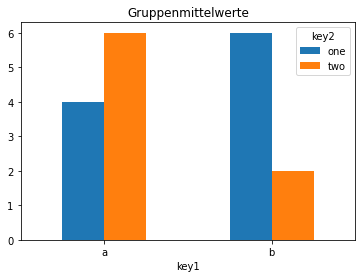

In [11]:
means.unstack().plot.bar(
    title='Gruppenmittelwerte', rot=0);

Weiteres Beispiel: In obigen Beispielen sind die Gruppenschlüssel Series bzw. Spalten von DataFrames. Die Gruppenschlüssel können aber *irgendwelche Arrays sein, solange sie die richtige Länge haben!*

In [12]:
df # Beispieldatei nochmals betrachten

,key1,key2,data1,data2
0,a,one,3,2
1,a,two,6,6
2,b,one,6,3
3,b,two,2,6
4,a,one,5,2


In [13]:
Gruppen = np.array(['G1', 'G2', 'G2', 'G1', 'G1'])
df.groupby(Gruppen).mean()

,data1,data2
G1,3.333333,3.333333
G2,6.000000,4.500000


Hinweis: Die Mittelwerte für `key1` und `key2` fehlen oben, da die Merkmale nicht numerisch sind.

Häufig befinden sich die Gruppierungsinformationen im selben DataFrame wie die Daten, die analysiert werden sollen. In diesem Fall können Spaltennamen (ob Zeichenfolgen, Zahlen oder andere Python-Objekte) als Gruppenschlüssel übergeben werden:

In [14]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,4.666667,3.333333
b,4.000000,4.500000


In [15]:
df.groupby(['key1', 'key2']).mean()

data1  data2
key1 key2              
a    one     4.0    2.0
     two     6.0    6.0
b    one     6.0    3.0
     two     2.0    6.0

Ungeachtet der Zielsetzung bei der Verwendung von `groupby` ist `size` eine allgemein nützliche GroupBy-Methode, die eine *Series* mit den Gruppengrössen zurückgibt:

In [16]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

Im Gegensatz zu `size` werden bei `count` die Anzahl Werte (ohne Fehlwerte!) *pro Spalte* ausgegeben.

In [17]:
df.groupby(['key1', 'key2']).count()

data1  data2
key1 key2              
a    one       2      2
     two       1      1
b    one       1      1
     two       1      1

Da keine `NaN` existieren, haben wir in beiden Spalten die gleichen Werte.

### Zwei Wege zu gruppieren

In [18]:
df.groupby('key1').data1.median()

key1
a    5.0
b    4.0
Name: data1, dtype: float64

In [19]:
df.data1.groupby(df.key1).median() 
# Achtung, df.key1 hier, nicht 'key1', da
# key1 nicht mehr in df.data1 enthalten ist!

key1
a    5.0
b    4.0
Name: data1, dtype: float64

- Beide Zeilen führen zum gleichen Resultat. 
- Die erste Zeile ist prägnanter. 
- *Die zweite Zeile ist insb. in grossen Datensätzen vorzuziehen, da weiger Daten aggregiert werden müssen.*

**Kontrollfragen:**

In [20]:
# Gegeben:
dflohn = pd.read_pickle('../weitere_Daten/dflohn.pkl')
dflohn_sample = (dflohn.sample(5, random_state=13)
                .sort_values(['Geschlecht', 'Zivilstand']))
dflohn_sample

,Lohn,Geschlecht,Alter,Zivilstand
Person,,,,
15,8681.0,m,23,v
38,5333.0,m,62,vw
84,9502.0,m,20,vw
44,6945.0,w,54,l
63,4888.0,w,19,v


In [21]:
# Frage 1: Was ist der Output?
dflohn_sample.groupby('Geschlecht').Lohn.min()

Geschlecht
m    5333.0
w    4888.0
Name: Lohn, dtype: float64

In [22]:
# Frage 2: Was ist der Output?
dflohn_sample.groupby(
    ['Geschlecht', 'Zivilstand']).Alter.min()

Geschlecht  Zivilstand
m           v             23
            vw            20
w           l             54
            v             19
Name: Alter, dtype: int32

In [23]:
# Frage 3: Was ist der Output?
Abteilung = [1, 2, 2, 1, 1]
dflohn_sample.Lohn.groupby(Abteilung).max()

1    8681.0
2    9502.0
Name: Lohn, dtype: float64

## Aggregation von Daten
- **Aggregationen nennt man Datenumwandlungen, die skalare Werte aus Arrays erzeugen.** 
- Die vorhergehenden Beispiele haben mehrere von ihnen verwendet.
- Viele häufig verwendete Aggregationen haben optimierte `groupby`-Implementierungen. Es sind dies: `count`, `sum`, `mean`, `median`, `std/var`, `min/max`, `prod`, `first/last` (erster und letzter Nicht-`NaN`-Wert).
- Zudem kann jede Methode aufgerufen werden, die auch für das gruppierte Objekt definiert ist. Beispiel:

In [24]:
# Übersichtliche Darstellung des Beispiel-DataFrames:
df2 = df.drop('key2', axis=1).sort_values(['key1', 'data1'])
df2

,key1,data1,data2
0,a,3,2
4,a,5,2
1,a,6,6
3,b,2,6
2,b,6,3


In [25]:
gruppiert = df2.groupby('key1')
gruppiert.quantile(0.25) # 25%-Quantil = 1. Quartil   
# Hinweis: Bei so wenigen Werten ist die Bestimmung
# des 1. Quartils nicht wirklich sinnvoll. 

,data1,data2
key1,,
a,4.0,2.00
b,3.0,3.75


Es fuktionieren auch Methoden wie `describe`, obwohl sie streng genommen keine Aggregationen sind:

In [26]:
gruppiert['data1'].describe()

,count,mean,std,min,25%,50%,75%,max
key1,,,,,,,,
a,3.0,4.666667,1.527525,3.0,4.0,5.0,5.5,6.0
b,2.0,4.000000,2.828427,2.0,3.0,4.0,5.0,6.0


- Schliesslich ist es auch möglich, *eigene* Aggregationen zu verwenden.
- Um eigene Aggregationsfunktionen zu verwenden, übergibt man eine Funktion, die ein Array aggregiert, an die **`aggregate`**- oder **`agg`**-Methode:

In [27]:
def spannweite(x):
    return x.max() - x.min()
gruppiert.agg(spannweite)

,data1,data2
key1,,
a,3,4
b,4,3


In [28]:
# Exkurs: oder direkt mit einer Lambda-Funktion 
# (keine explizite Funktionsdefinition nötig):
gruppiert.agg(lambda x: x.max() - x.min())

,data1,data2
key1,,
a,3,4
b,4,3


### Weitere Funktionalitäten dargestellt am "Trinkgelddatensatz":

In [29]:
tips = pd.read_csv('../examples/tips.csv')
# Variable hinzufügen, welche Trinkgeld als
# Prozent des Rechnungstotals ausdrückt:
tips['tip_pct'] = tips.tip / tips.total_bill
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [30]:
grouped = tips.groupby(['day', 'smoker'])
grouped.mean()   # Mittelwerte 

total_bill       tip      size   tip_pct
day  smoker                                          
Fri  No       18.420000  2.812500  2.250000  0.151650
     Yes      16.813333  2.714000  2.066667  0.174783
Sat  No       19.661778  3.102889  2.555556  0.158048
     Yes      21.276667  2.875476  2.476190  0.147906
Sun  No       20.506667  3.167895  2.929825  0.160113
     Yes      24.120000  3.516842  2.578947  0.187250
Thur No       17.113111  2.673778  2.488889  0.160298
     Yes      19.190588  3.030000  2.352941  0.163863

In [31]:
# Berechnungen nur für eine Variable:
grouped['tip_pct'].mean()   

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [33]:
grouped['tip_pct'].agg('mean')  # gleiches Ergebnis

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [34]:
# Mit agg können wir auch mehrere Aggregationen 
# gleichzeitig durchführen:
grouped['tip_pct'].agg(['mean', 'std', spannweite])
# 'mean' und 'std' sind Abkürzungen für np.mean
# und np.std. 

mean       std  spannweite
day  smoker                                
Fri  No      0.151650  0.028123    0.067349
     Yes     0.174783  0.051293    0.159925
Sat  No      0.158048  0.039767    0.235193
     Yes     0.147906  0.061375    0.290095
Sun  No      0.160113  0.042347    0.193226
     Yes     0.187250  0.154134    0.644685
Thur No      0.160298  0.038774    0.193350
     Yes     0.163863  0.039389    0.151240

**Kontrollfrage:**

In [ ]:
# Gegeben:
dflohn_sample.sort_values('Zivilstand')

In [ ]:
# Frage: Was ist der Output?
dflohn_sample.groupby('Zivilstand'
              ).Alter.agg(['size', 'sum'])

## Die Apply-Methode
Die allgemeinste GroupBy-Methode ist `apply`, welche Gegenstand der folgenden Ausführungen ist. Mit `apply` können Funktionen entlang einer Achse ausgeführt werden.

In [35]:
dflohn.groupby('Geschlecht').Lohn.apply(np.mean)

Geschlecht
m    5838.918367
w    5850.380000
Name: Lohn, dtype: float64

Wie zuvor gezeigt, könnte man diese Aggregation auch mit `agg` oder direkt mit `mean` umsetzen.

In [36]:
dflohn.groupby('Geschlecht').Lohn.agg(np.mean)

Geschlecht
m    5838.918367
w    5850.380000
Name: Lohn, dtype: float64

In [ ]:
# oder:
dflohn.groupby('Geschlecht').Lohn.agg('mean')

In [ ]:
# oder direkt:
dflohn.groupby('Geschlecht').Lohn.mean()

Mit `apply` können aber neben Aggregationen weitere Funktionen auf Gruppen angewendet werden. Kehren wir hierzu zum vorherigen Trinkgeld-Datensatz zurück. Angenommen wir wollen eine Funktion schreiben, welche die `n` (Default `n=3`) grössten Werte der Spalte `by` (Default `by=tip_pct`) zurückgibt.

In [ ]:
def top(df, n=3, by='tip_pct'): 
    # "Positional-Argument" (df) vor "Keyword-Argumenten (n, by)"
    return df.sort_values(by=by, ascending=False)[:n]

top(tips, by='tip', n=1)  # höchstes (absolutes) Trinkgeld

Ohne weitere Argumente gelten die Defaults, also `n=3` und `by=tip_pct`, also die drei höchsten *prozentualen* Trinkgelder relativ zum Rechnungsbetrag.

In [ ]:
top(tips)

Wenn wir nun beispielsweise nach der Spalte `smoker` gruppieren und `apply` mit dieser Funktion aufrufen, erhalten wir Folgendes:

In [ ]:
tips.groupby('smoker').apply(top)

Wir erhalten somit die höchsten drei prozentualen Trinkgleder *pro Gruppe*. Auch hier könnte man die Defaults überschreiben:

In [ ]:
# Pro Gruppe die zwei höchsten absoluten Trinkgelder:
tips.groupby('smoker').apply(top, by='tip', n=2)

Wir erhalten nun die zwei höchsten (absoluten) Trinkgelder pro Gruppe (Nichtraucher, Raucher).

**Kontrollfrage:**

In [ ]:
# Gegeben:
dflohn_sample

In [ ]:
# Frage: Was ist der Output?
dflohn_sample.groupby('Geschlecht').apply(
            top, by='Lohn', n=1)

### Beispiel: Standardabweichung der Tagesrenditen separat pro Jahr
Als Beispiel betrachten wir einen Finanzdatensatz, der von Yahoo-Finance stammt, mit Tagesendkursen einiger Aktien und dem S&P500-Index (Symbol SPX):

In [ ]:
close_px = pd.read_csv('../examples/stock_px_2.csv', 
                       parse_dates=True, index_col=0)
close_px.head()  # die ersten 5 Zeilen

In [ ]:
close_px.tail()   # die letzten 5 Zeilen

Die praktische Methode `pct_change` berechnet die prozentaulen Veränderungen aus den Kursdaten (also die Renditen).

In [ ]:
returns = close_px.pct_change().dropna()
# Wir verwenden dropna, da am Anfang des DataFrames
# durch die Renditeberechnungen NaN entstanden.
returns.head()

Standardabweichungen der Tagesrenditen über den ganzen Zeitraum:

In [ ]:
returns.std()

Als nächstes berechnen wir die Korrelationen der Aktien mit dem Aktienindex (SPX) *pro Jahr*. Zuerst halten wir fest, dass man die Jahre wie folgt aus dem Datum ziehen kann (Details folgen im Kapitel 11):

In [ ]:
returns.index.year

Wir können somit `returns.index.year` als Gruppierungsvektor übergeben:

In [ ]:
Std_pro_Jahr = returns.groupby(returns.index.year).std()
Std_pro_Jahr

Die Standardabweichungen steigen mit der Finanzkrise an und sinken dann wieder. Wir können dies auch graphisch verdeutlichen.

In [ ]:
Std_pro_Jahr.plot(
     title='Entwicklung der Standardabweichungen der Tagesrenditen');

**Kontrollfrage:**

In [ ]:
# Gegeben:
Auto = pd.read_csv('../weitere_Daten/Auto.csv', sep=';')
Auto.origin.replace({1: 'USA', 2: 'Europa', 3:'Japan'}, inplace=True)
Auto.tail()

In [ ]:
# Gegeben:
def MittlereAnzahlBuchstaben(Zeichenkette):
    return Zeichenkette.str.len().mean()

In [ ]:
# Frage: Was bedeutet der Output?
Auto.groupby('origin')['name'].apply(MittlereAnzahlBuchstaben)

## Pivot-Tabellen und Kreuztabellierung

In [ ]:
tips.head()

Angenommen wir wollen Gruppenmittelwerte arrangiert nach `day` und `smoker`:

In [ ]:
tips.groupby(['day', 'smoker']).mean()

Diese Tabelle ist der Default der Methode `pivot_table`. Somit hätten wir die Tabelle auch wie folgt erhalten (die Spalten folgen aber einer anderen Reihenfolge):

In [ ]:
tips.pivot_table(index=['day', 'smoker'])

Die Methode erlaubt mehr: Es sollen die Grössen der Restaurantbesuchergruppen nach Tageszeit, Wochentag und ob sie rauchen oder nicht untersucht werden.

In [ ]:
tips.pivot_table(
    values  = 'size',   # values: Welche Variable soll ausgewertet werden (Default Mittelwert)
    index   = ['time', 'day'], # index: Gruppierung/Aufgliederung im Index
    columns = 'smoker',        # columns: Aufgliederung in den Spalten
    aggfunc = 'mean')          # Die Aggregationsfunktion 'mean' ist der Default
                               # und könnte somit weggelassen werden.

Inklusive "Randstatistiken" mit dem Argument `margins=True`:

In [ ]:
tips.pivot_table(values  = ['size'], 
                 index   = ['time', 'day'],
                 columns = 'smoker', 
                 margins=True)

Um eine andere Aggregationsfunktion zu verwenden (als `mean`), übergibt man diese an `aggfunc`. Beispielsweise erhalten wir mit `len` oder `'count'` (`'count'`, nicht `count`) die absoluten Häufigkeiten.

In [ ]:
tab = tips.pivot_table(values  = ['total_bill'], 
                       index   = ['time', 'smoker'], 
                       columns = 'day', 
                       aggfunc='count', 
                       margins=True)
tab

Wenn einige Zellen leer bzw. `NaN` sind, kann es sinnvoll sein, einen `fill_value` zu übergeben:

In [ ]:
tab = tips.pivot_table(values='size', 
                       index=['time', 'smoker'], 
                       columns='day', 
                       aggfunc='count', fill_value=0,
                       margins=True)
tab

**Kontrollfrage:**

In [ ]:
# Gegeben:
Auto.head()

In [ ]:
# Frage: Wie ist der Output zu interpretieren?
subset = Auto.cylinders.isin([4, 6, 8])  # nur Autos mit 4, 6 oder 8 Zylindern
Auto[subset].pivot_table(values  = 'mpg',
                         index   = 'origin',
                         columns = 'cylinders',
                         margins=True)

### Kreuztabellen
Eine **Kreuztabelle** (auch **Kontingenztabelle** oder **Kontingenztafel** genannt) ist ein *Spezialfall einer Pivot-Tabelle*, die Gruppen**häufigkeiten** darstellt. Beispiele:

In [ ]:
pd.crosstab(index=Auto.cylinders, 
            columns=Auto.origin,
            margins=True)

Lesebeispiel: Es gibt im Datensatz 199 Autos mit 4 Zylindern, wobei 61 davon aus Europa stammen.  

Das nächste Beispiel wiederholt eine Tabelle, die wir zuvor mit `pivot_table` erstellt haben.

In [ ]:
pd.crosstab(index   = [tips.time, tips.smoker], 
            columns = tips.day, 
            margins = True)

Weiteres Beispiel:

In [ ]:
dflohn = pd.read_pickle('../weitere_Daten/dflohn.pkl')
dflohn.head()

In [ ]:
pd.crosstab(index = dflohn.Geschlecht, 
            columns = dflohn.Zivilstand, 
            margins = True)

11 Personen im Datensatz sind männlich (m) und geschieden (g) usw.

In [ ]:
# Relative Häufigkeitstabelle:
pd.crosstab(index     = dflohn.Geschlecht, 
            columns   = dflohn.Zivilstand, 
            normalize = True, 
            margins   = True)

11% der Presonen im Datensatz sind männlich (m) und geschieden (g) usw.

**Bedingte Häufigkeitstabellen:**

Oft ist es hilfreich, wenn man bedingte relative Häufigkeiten ausweist um Strukturunterschiede in den Daten festzustellen.

In [ ]:
tab1 = pd.crosstab(
          index     = dflohn.Geschlecht, 
          columns   = dflohn.Zivilstand, 
          normalize = 'columns',     # Spalten auf 1 normieren.
          margins   = True)
tab1.round(2)

Die relativen Häufigkeiten sind pro Spalte (Zivilstand) "normalisiert". Somit sind die Spaltentotale jeweils 1 (100%). Beispielsweise sind (im Datensatz) unter den Geschiedenen (g) 44% Männer und 56% Frauen. Insgesamt (All) sind im Datensatz 50% Männer und 50% Frauen.

**Kontrollfrage**

In [ ]:
# Frage: Wie ist der erste Wert in der Tabelle (unter "m" und "g") zu interpretieren?
tab2 = pd.crosstab(index     = dflohn.Geschlecht, 
                   columns   = dflohn.Zivilstand, 
                   normalize = 'index', 
                   margins   = True)
tab2.round(2)

## Fazit
- Die Beherrschung der Datengruppierungstools von Pandas ist sowohl bei der Datenbereinigung als auch bei der statistischen Analyse oder Modellierung sehr hilfreich.
- Im nächsten Kapitel befassen wir uns mit Zeitreihendaten.